# Image Captioning
นายเตชิต ลอยมา 64102010293

นางสาวอารียา ตรีกุล 64102010307

นายจารุภัทร ตรีธนูชัย 64102010493

นางสาวพิมพ์ศจี พบหิรัญโสภณ 64102010495

#1.Describe the model: input-output

-input:รูป

 output:แคปชั่น  

 model: Hugging Face(Image Captioning):BlipForConditionalGeneration

## Set-up environment

In [ ]:
!pip install git+https://github.com/huggingface/transformers.git@main

  Cloning https://github.com/huggingface/transformers.git (to revision main) to /tmp/pip-req-build-uz87ni1f
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-uz87ni1f
  Resolved https://github.com/huggingface/transformers.git to commit 238d2e3c44366aba9dc5c770c95475765a6725cb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install -q datasets

#2.Show the code for running the model

## Load from the Hub


โหลดโมลเดลมาจากgithub

In [ ]:
from transformers import BlipForConditionalGeneration, AutoProcessor
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
model = BlipForConditionalGeneration.from_pretrained("ybelkada/blip-image-captioning-base-football-finetuned").to(device)
processor = AutoProcessor.from_pretrained("ybelkada/blip-image-captioning-base-football-finetuned")

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


preprocessor_config.json:   0%|          | 0.00/431 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/488 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

check the results on our train dataset

In [ ]:
from datasets import load_dataset

dataset = load_dataset("ybelkada/football-dataset", split="train")

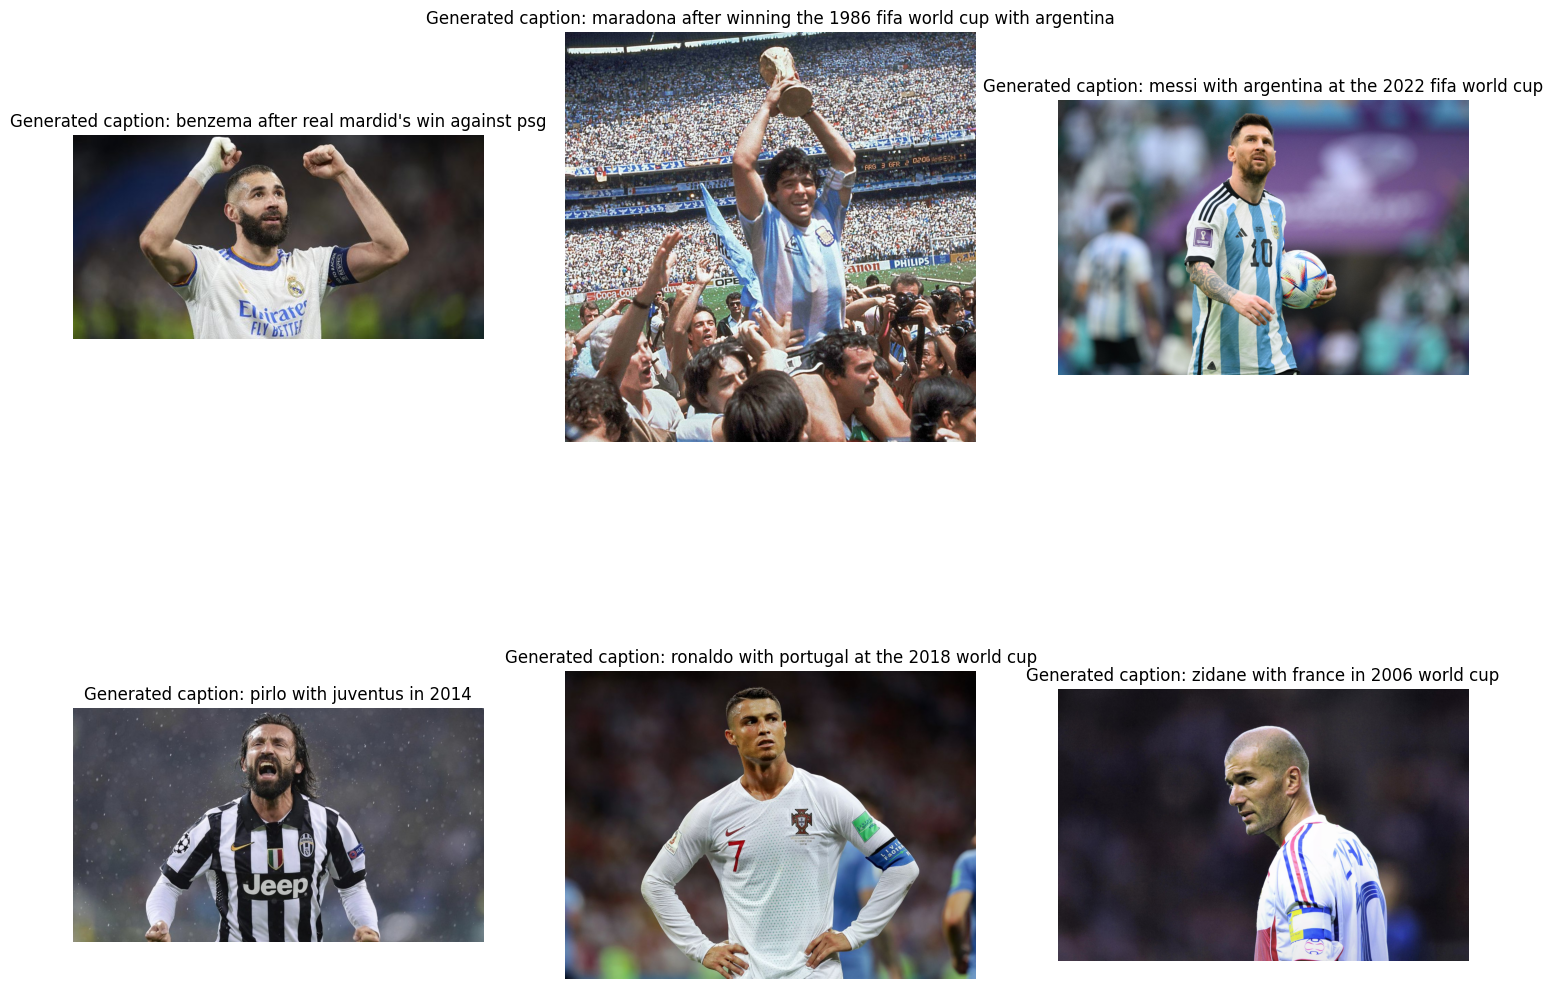

In [ ]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(18, 14))

# prepare image for the model
for i, example in enumerate(dataset):
  image = example["image"]
  inputs = processor(images=image, return_tensors="pt").to(device)
  pixel_values = inputs.pixel_values

  generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  fig.add_subplot(2, 3, i+1)
  plt.imshow(image)
  plt.axis("off")
  plt.title(f"Generated caption: {generated_caption}")

#3.Show a custom dataset for fine tuning


## Load the image captioning dataset

เตรียมcustom datasetสำหรับการทำfine tuning

In [ ]:
from datasets import load_dataset

dataset = load_dataset("ybelkada/football-dataset", split="train")

In [ ]:
len(dataset)

6

In [ ]:
dataset['text'][:]

["Benzema after Real Mardid's win against PSG",
 'Maradona after winning the 1986 FIFA World Cup with Argentina',
 'Messi with Argentina at the 2022 FIFA World Cup',
 'Pirlo with Juventus in 2014',
 'Ronaldo with Portugal at the 2018 World Cup',
 'Zidane with France in 2006 World Cup']

Benzema after Real Mardid's win against PSG
------------------------------------------------------------


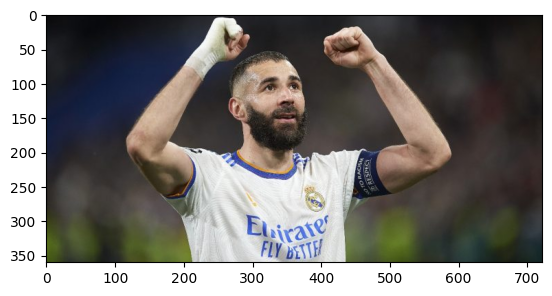



Maradona after winning the 1986 FIFA World Cup with Argentina
------------------------------------------------------------


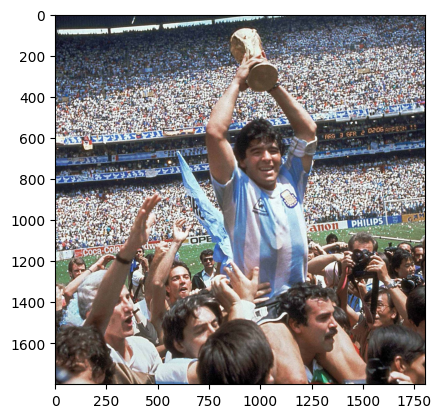



Messi with Argentina at the 2022 FIFA World Cup
------------------------------------------------------------


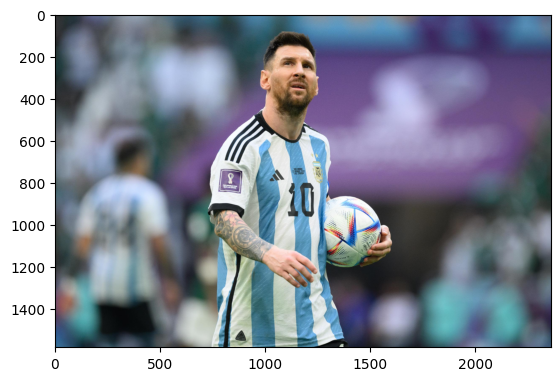



Pirlo with Juventus in 2014
------------------------------------------------------------


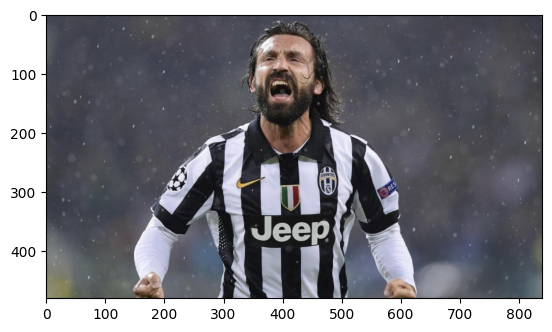



Ronaldo with Portugal at the 2018 World Cup
------------------------------------------------------------


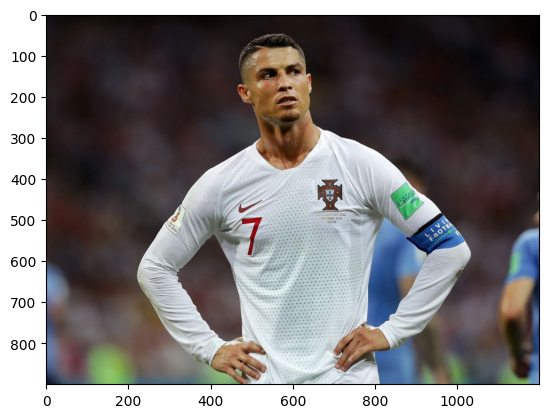



Zidane with France in 2006 World Cup
------------------------------------------------------------


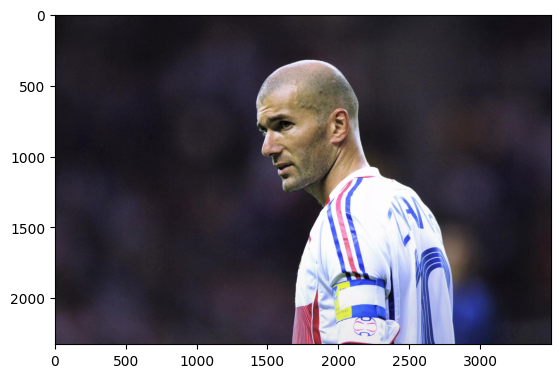

In [ ]:
import matplotlib.pyplot as plt

for i in range(len(dataset)):
    print(dataset[i]["text"])
    print('-'*60)
    plt.figure()
    plt.imshow(dataset[i]["image"])
    plt.show()
    print('\n')

In [ ]:
from sklearn.model_selection import train_test_split

# Convert your dataset to a list of tuples
full_dataset = [(image, text) for image, text in zip(dataset['image'], dataset['text'])]

# Split the full dataset into train and test sets
train_data, test_data = train_test_split(full_dataset, test_size=0.2)

# Extract images and texts separately for train and test sets
train_images, train_texts = zip(*train_data)
test_images, test_texts = zip(*test_data)

## Create PyTorch Dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, images, texts, processor):
        self.images = images
        self.texts = texts
        self.processor = processor

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        text = self.texts[idx]
        encoding = self.processor(images=image, text=text, padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

In [ ]:
# Create a ImageCaptioningDataset for the train and test sets
train_dataset = ImageCaptioningDataset(train_images, train_texts, processor)
test_dataset = ImageCaptioningDataset(test_images, test_texts, processor)

# Create a DataLoader for the train and test sets
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=2)

#4.Show the code for fine-tuning the model

ทำ fine tuning

## Load model and processor

In [ ]:
from transformers import AutoProcessor, BlipForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


## Train the model

train the model


Epoch: 0


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Loss: 13.039477348327637
Loss: 10.28465461730957
Training accuracy: 0.001953125
Epoch: 1
Loss: 10.2071533203125
Loss: 10.20419692993164
Training accuracy: 0.001953125
Epoch: 2
Loss: 10.166208267211914
Loss: 10.18900203704834
Training accuracy: 0.001953125
Epoch: 3
Loss: 10.160574913024902
Loss: 10.12498950958252
Training accuracy: 0.001953125
Epoch: 4
Loss: 10.143804550170898
Loss: 10.099576950073242
Training accuracy: 0.001953125
Epoch: 5
Loss: 10.08790111541748
Loss: 10.116315841674805
Training accuracy: 0.001953125
Epoch: 6
Loss: 10.10635757446289
Loss: 10.05627155303955
Training accuracy: 0.001953125
Epoch: 7
Loss: 10.066082000732422
Loss: 10.042939186096191
Training accuracy: 0.001953125
Epoch: 8
Loss: 9.999565124511719
Loss: 9.962965965270996
Training accuracy: 0.001953125
Epoch: 9
Loss: 9.668505668640137
Loss: 9.288064002990723
Training accuracy: 0.001953125
Epoch: 10
Loss: 9.106221199035645
Loss: 8.941476821899414
Training accuracy: 0.0009765625
Epoch: 11
Loss: 8.78516674041748

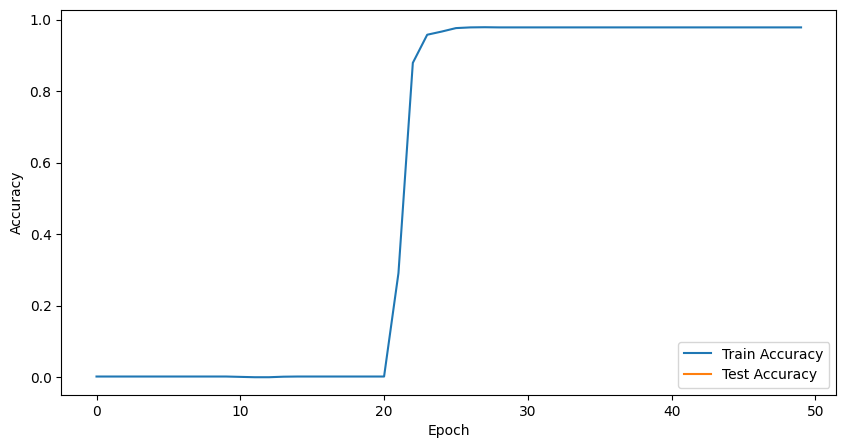

In [ ]:
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

train_accuracies = []
test_accuracies = []

# Training
model.train()
for epoch in range(50):
    print("Epoch:", epoch)
    correct_predictions = 0
    total_predictions = 0
    for idx, batch in enumerate(train_dataloader):
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)

        outputs = model(input_ids=input_ids,
                        pixel_values=pixel_values,
                        labels=input_ids)

        loss = outputs.loss
        logits = outputs.logits

        # Calculate accuracy
        predictions = torch.argmax(logits, dim=-1)
        correct_predictions += (predictions == input_ids).sum().item()
        total_predictions += input_ids.numel()

        print("Loss:", loss.item())

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

    train_accuracy = correct_predictions / total_predictions
    train_accuracies.append(train_accuracy)
    print(f"Training accuracy: {train_accuracy}")

# Testing
model.eval()
with torch.no_grad():
    correct_predictions = 0
    total_predictions = 0
    for idx, batch in enumerate(test_dataloader):  # assuming you have a separate test_dataloader
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)

        outputs = model(input_ids=input_ids,
                        pixel_values=pixel_values)

        logits = outputs.logits

        # Calculate accuracy
        predictions = torch.argmax(logits, dim=-1)
        correct_predictions += (predictions == input_ids).sum().item()
        total_predictions += input_ids.numel()

    test_accuracy = correct_predictions / total_predictions
    test_accuracies.append(test_accuracy)
    print(f"Testing accuracy: {test_accuracy}")

# Plot accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Epoch: 0
Loss: 0.38144904375076294
Loss: 3.1054093837738037
Training accuracy: 0.48876953125
Epoch: 1
Loss: 0.9975893497467041
Loss: 0.5318661332130432
Training accuracy: 0.97802734375
Epoch: 2
Loss: 0.4553578495979309
Loss: 0.4079091548919678
Training accuracy: 0.97802734375
Epoch: 3
Loss: 0.41906094551086426
Loss: 0.43111860752105713
Training accuracy: 0.97802734375
Epoch: 4
Loss: 0.4461520314216614
Loss: 0.4019949734210968
Training accuracy: 0.97802734375
Epoch: 5
Loss: 0.4176333248615265
Loss: 0.43025341629981995
Training accuracy: 0.97802734375
Epoch: 6
Loss: 0.4176148474216461
Loss: 0.43024352192878723
Training accuracy: 0.97802734375
Epoch: 7
Loss: 0.4302433133125305
Loss: 0.4176141917705536
Training accuracy: 0.97802734375
Epoch: 8
Loss: 0.4441737234592438
Loss: 0.4036838114261627
Training accuracy: 0.97802734375
Epoch: 9
Loss: 0.4302433133125305
Loss: 0.4176141917705536
Training accuracy: 0.97802734375
Testing accuracy: 0.97265625


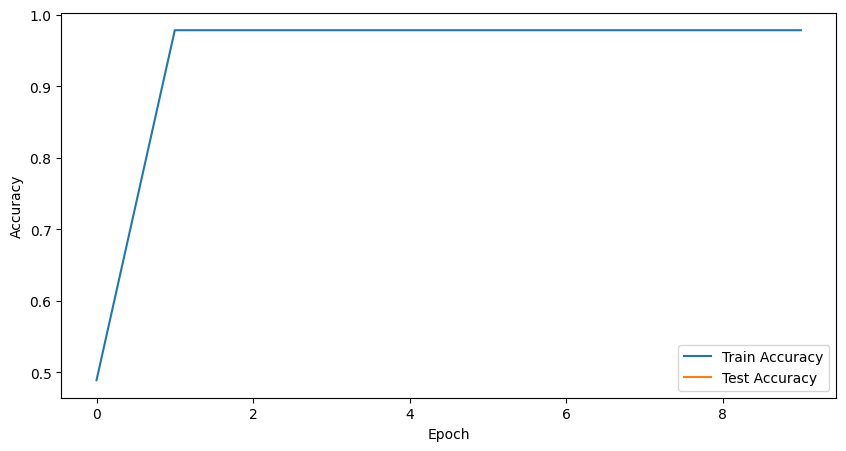

In [ ]:
import torch.optim as optim
from torch import nn
# Define the optimizer
optimizer = optim.AdamW(model.parameters(), lr=5e-4)

# Define the learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Move the model to the device
model.to(device)

train_accuracies = []
test_accuracies = []

# Training
model.train()
for epoch in range(10):  # Use only 10 epochs
    print("Epoch:", epoch)
    correct_predictions = 0
    total_predictions = 0
    for idx, batch in enumerate(train_dataloader):
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)

        # Forward pass without labels for fine-tuning
        outputs = model(input_ids=input_ids,
                        pixel_values=pixel_values)

        # Calculate loss using your own criterion (e.g., CrossEntropyLoss)
        loss = nn.CrossEntropyLoss()(outputs.logits.view(-1, outputs.logits.size(-1)), input_ids.view(-1))

        # Calculate accuracy
        predictions = torch.argmax(outputs.logits, dim=-1)
        correct_predictions += (predictions == input_ids).sum().item()
        total_predictions += input_ids.numel()

        print("Loss:", loss.item())

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

    # Update the learning rate
    scheduler.step()

    train_accuracy = correct_predictions / total_predictions
    train_accuracies.append(train_accuracy)
    print(f"Training accuracy: {train_accuracy}")

# Testing
model.eval()
with torch.no_grad():
    correct_predictions = 0
    total_predictions = 0
    for idx, batch in enumerate(test_dataloader):  # assuming you have a separate test_dataloader
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)

        outputs = model(input_ids=input_ids,
                        pixel_values=pixel_values)

        # Calculate accuracy
        predictions = torch.argmax(outputs.logits, dim=-1)
        correct_predictions += (predictions == input_ids).sum().item()
        total_predictions += input_ids.numel()

    test_accuracy = correct_predictions / total_predictions
    test_accuracies.append(test_accuracy)
    print(f"Testing accuracy: {test_accuracy}")

# Plot accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

ในโค้ดนี้ เราได้เพิ่ม scheduler ที่จะลด learning rate ลงทุก ๆ 10 รอบ โดยลดลงเป็น 1/10 ของค่าเดิม การลด learning rate ลงเมื่อความก้าวหน้าในการฝึกฝนลดลงจะช่วยให้โมเดลสามารถ “ปรับตัว” ได้ดีขึ้นและลดโอกาสที่จะเกิด overfitting

#5.Compare the performance before and after fine-tuning


-หลังจากการทำFine-tune โมเดลสามารถเรียนรู้ได้เร็วขึ้น

#6.Build a model from scratch, train the model with the custom dataset and compare the result with the pre-trained model

In [ ]:
import torch
from torch import nn

class ImageCaptioningModel(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(ImageCaptioningModel, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.init_weights()

    def init_weights(self):
        self.embed.weight.data.uniform_(-0.1, 0.1)
        self.linear.weight.data.uniform_(-0.1, 0.1)
        self.linear.bias.data.fill_(0)

    def forward(self, features, captions):
        embeddings = self.embed(captions)
        inputs = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(inputs)
        outputs = self.linear(hiddens)
        return outputs

In [ ]:
from torch.utils.data import Dataset, DataLoader

# สร้าง Dataset สำหรับข้อมูลภาพและข้อความ
class ImageCaptioningDataset(Dataset):
    def __init__(self, images, texts, transform=None):
        self.images = images
        self.texts = texts
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]  # สำหรับข้อมูลภาพ
        text = self.texts[idx]    # สำหรับข้อความ

        # ในกรณีที่มีการใช้การแปลงรูปภาพ (ถ้ามี)
        if self.transform:
            image = self.transform(image)

        return image, text

# สร้าง instances ของ Dataset สำหรับ train และ test sets
train_dataset = ImageCaptioningDataset(train_images, train_texts)
test_dataset = ImageCaptioningDataset(test_images, test_texts)

# สร้าง DataLoader สำหรับ train และ test sets
batch_size = 32  # กำหนด batch size ตามที่ต้องการ
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Encoder Model
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.dense = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.dense(x)
        x = torch.relu(x)
        x = self.dropout(x)
        return x

# Decoder Model
class Decoder(nn.Module):
    def __init__(self, output_size, hidden_size):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, x, hidden):
        x = self.embedding(x)
        x, hidden = self.lstm(x, hidden)
        x = self.fc(x)
        x = self.softmax(x)
        return x, hidden

# Image Captioning Model
class ImageCaptioningModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = Encoder(input_size, hidden_size)
        self.decoder = Decoder(output_size, hidden_size)

    def forward(self, image, caption):
        encoded_image = self.encoder(image)
        hidden = (encoded_image.unsqueeze(0), encoded_image.unsqueeze(0))
        outputs, _ = self.decoder(caption, hidden)
        return outputs

# ตัวอย่างการสร้างโมเดล Image Captioning
input_size =  len(train_dataloader)# กำหนดขนาดของข้อมูลนำเข้า
output_size =  len(test_dataloader)# กำหนดขนาดของข้อมูลเป้าหมาย
hidden_size = 128  # กำหนดขนาด hidden state

# Instantiate the Image Captioning Model
image_captioning_model = ImageCaptioningModel(input_size, output_size, hidden_size)

# ทำการ compile model ด้วย loss function และ optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(image_captioning_model.parameters(), lr=0.001)


In [ ]:
# Training Loop
num_epochs = 10  # Set the number of epochs
for epoch in range(num_epochs):
    image_captioning_model.train()
    for image, caption in train_dataset:  # Iterate through the training dataset
        optimizer.zero_grad()

        # Preprocess the image and caption to tensors before passing to the model
        image_tensor = preprocess_image(image)  # Convert image to tensor
        caption_tensor = preprocess_caption(caption)  # Convert caption to tensor

        # Forward pass
        outputs = image_captioning_model(image_tensor, caption_tensor)

        # Calculate loss
        loss = criterion(outputs, caption_tensor)

        # Backpropagation
        loss.backward()
        optimizer.step()

# Testing the Model
image_captioning_model.eval()
total_correct = 0
total_samples = 0

with torch.no_grad():
    for image, caption in test_dataset:  # Iterate through the test dataset
        # Preprocess the image and caption to tensors before passing to the model
        image_tensor = preprocess_image(image)  # Convert image to tensor
        caption_tensor = preprocess_caption(caption)  # Convert caption to tensor

        outputs = image_captioning_model(image_tensor, caption_tensor)
        _, predicted = torch.max(outputs.data, 2)
        total_samples += caption_tensor.size(0) * caption_tensor.size(1)
        total_correct += (predicted == caption_tensor).sum().item()

# Calculate accuracy
accuracy = total_correct / total_samples
print(f'Test Accuracy: {accuracy * 100:.2f}%')


NameError: ignored

In [ ]:
 for images, captions in train_dataset:
  pass

images



"Benzema after Real Mardid's win against PSG"

In [ ]:
from tensorflow.keras.layers import Dropout

# สร้างโมเดล
# Encoder
encoder_input = Input(shape=(feature_size,))
encoder_dense = Dense(128, activation='relu')(encoder_input)
encoder_dropout = Dropout(0.2)(encoder_dense)  # เพิ่ม Dropout layer ระหว่าง Dense layer
encoder_model = Model(encoder_input, encoder_dropout)

# Decoder
decoder_input = Input(shape=(None,))
decoder_embedding = Embedding(input_dim=vocab_size, output_dim=128)(decoder_input)
decoder_lstm = LSTM(128, return_sequences=True)(decoder_embedding, initial_state=[encoder_dropout, encoder_dropout])
decoder_dense = Dense(vocab_size, activation='softmax')(decoder_lstm)
decoder_model = Model([encoder_input, decoder_input], decoder_dense)

# สร้างโมเดลสำหรับการ train
model = Model([encoder_input, decoder_input], decoder_dense)

# compile โมเดล
model.compile(loss='categorical_crossentropy', optimizer='adam')

# สามารถนำ model ไป train ต่อได้ตามที่ต้องการ
model.summary()


NameError: ignored

In [ ]:
def predict(image, model, device):
    model.eval()
    with torch.no_grad():
        # Assuming that your image is already in the required format (3D tensor)
        image = image.to(device)

        # Prepare the inputs for the model
        pixel_values = image.unsqueeze(0)  # Add a batch dimension

        # Generate the initial input_ids (start with just the start-of-sentence token)
        input_ids = torch.ones((1, 1)).long().to(device)  # The "1" here is the ID for the start-of-sentence token in your vocabulary

        # Loop until the model generates an end-of-sentence token or we reach a maximum length
        for _ in range(100):  # Maximum length of 100 tokens
            outputs = model(pixel_values, input_ids)
            predictions = torch.argmax(outputs.logits, dim=-1)

            # Add the last predicted token to the input_ids
            input_ids = torch.cat([input_ids, predictions[:, -1].unsqueeze(-1)], dim=-1)

            # Check if the last predicted token is the end-of-sentence token
            if predictions[0, -1].item() == 2:  # Assuming that "2" is the end-of-sentence token in your vocabulary
                break

        # Convert the predicted token IDs to words
        predicted_caption = ' '.join([vocab.id_to_word[id.item()] for id in input_ids[0]])  # Assuming you have a `vocab` object with an `id_to_word` method

    return predicted_caption

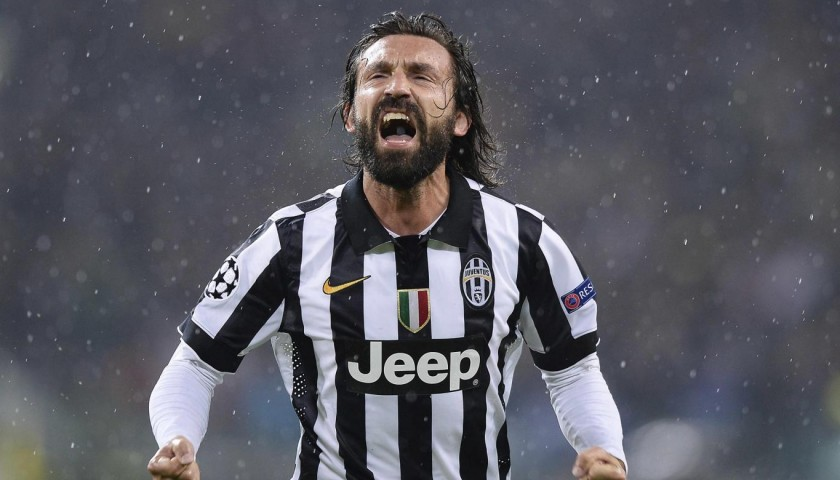

In [ ]:
train_images[2]

In [ ]:
model.to(device)

BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-0

In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

# Define the tokenizer
tokenizer = get_tokenizer('basic_english')

# Define a function to yield tokens from the dataset
def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

# Create an iterator over the texts in your dataset
texts = train_texts + test_texts  # Combine train and test texts
text_iter = iter(texts)

# Build the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(text_iter))

# Add special tokens
vocab.insert_token('<pad>', 0)  # Padding token
vocab.insert_token('<sos>', 1)  # Start-of-sentence token
vocab.insert_token('<eos>', 2)  # End-of-sentence token

In [ ]:
# Print the keys in the encoding dictionary
print(encoding.keys())


dict_keys(['pixel_values', 'input_ids', 'attention_mask'])


In [ ]:
itos = vocab.get_itos()

In [ ]:
itos = vocab.get_itos()
# สมมติว่า 'pixel_values' เก็บข้อมูลรูปภาพในพจนานุกรม encoding
image_data = encoding['pixel_values']

# ดำเนินการเตรียมข้อมูลสำหรับโมเดล
pixel_values = image_data.to(device)  # ย้ายข้อมูลไปยังอุปกรณ์ที่ใช้งาน (device)

# เตรียมข้อมูลเริ่มต้นสำหรับ input_ids (เริ่มต้นด้วย token เริ่มข้อความ)
input_ids = torch.ones((1, 1)).long().to(device)  # 1 คือ ID ของ token เริ่มต้นของประโยคในพจนานุกรมของคุณ

# ลูปการทำนายจนกว่าโมเดลจะสร้าง token สิ้นสุดประโยคหรือครบความยาวสูงสุด
for _ in range(100):  # ความยาวสูงสุดของประโยคที่สร้างได้
    outputs = model(pixel_values, input_ids)
    predictions = torch.argmax(outputs.logits, dim=-1)

    # เพิ่ม token ที่ทำนายล่าสุดเข้าไปใน input_ids
    last_prediction = predictions[:, -1].unsqueeze(-1)
    if (last_prediction == 2).any():  # ตรวจสอบว่ามี token สิ้นสุดประโยคอยู่ในการทำนายหรือไม่
        break

    # เตรียมขนาดที่สอดคล้องกันก่อนที่จะทำการ Concatenate
    #last_prediction = last_prediction.view(1, 1, 1, -1)  # ปรับขนาด tensor เพื่อให้มีขนาดที่สอดคล้องกัน
    #input_ids = torch.cat([input_ids, last_prediction], dim=-1)
    last_prediction = last_prediction.squeeze()  # ลด dimensions เหลือ 2 มิติ
    input_ids = torch.cat([input_ids, last_prediction.unsqueeze(0)], dim=-1)  # ทำการ concatenate ระหว่าง input_ids และ last_prediction

# แปลง token ที่ทำนายเป็นคำ
# สร้างตัวแปร predicted_caption เพื่อเก็บ token IDs ที่ทำนายได้
predicted_caption_ids = input_ids.squeeze().tolist()

# สมมติว่า predicted_caption_ids เป็น token IDs ที่คุณได้จากการทำนาย
# เรียกใช้ itos จาก vocab
itos = vocab.get_itos()

# แปลง token IDs ที่ได้จากการทำนายเป็นคำศัพท์
predicted_caption = ' '.join([itos[id] for id in predicted_caption_ids if id < len(itos)])
print(predicted_caption)

<sos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# สร้างโมเดล CNN สำหรับการสกัดคุณลักษณะของภาพ
image_model = Sequential()
image_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
image_model.add(MaxPooling2D((2, 2)))
image_model.add(Conv2D(64, (3, 3), activation='relu'))
image_model.add(MaxPooling2D((2, 2)))
image_model.add(Conv2D(128, (3, 3), activation='relu'))
image_model.add(MaxPooling2D((2, 2)))
image_model.add(Conv2D(128, (3, 3), activation='relu'))
image_model.add(MaxPooling2D((2, 2)))
image_model.add(Flatten())
image_model.add(Dense(256, activation='relu'))

# ตัวอย่างโมเดล LSTM สำหรับสร้างคำอธิบายของภาพ
from tensorflow.keras.layers import Embedding, LSTM

# สร้างโมเดล LSTM
caption_model = Sequential()
caption_model.add(Embedding(vocab_size, 256, input_length=max_sequence_length))
caption_model.add(LSTM(256))

# รวมโมเดล CNN และ RNN เข้าด้วยกัน
from tensorflow.keras.layers import concatenate

combined = concatenate([image_model.output, caption_model.output])
dense = Dense(256, activation='relu')(combined)
outputs = Dense(vocab_size, activation='softmax')(dense)

# สร้างโมเดลแบบสมบูรณ์
from tensorflow.keras.models import Model

model = Model(inputs=[image_model.input, caption_model.input], outputs=outputs)

# Compile และฝึกสอนโมเดล
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit([images, padded_sequences], to_categorical(padded_sequences, num_classes=vocab_size), epochs=10, batch_size=32)


NameError: ignored

In [ ]:
import datasets

# โหลด Dataset ฟุตบอล
dataset = datasets.load_dataset('ybelkada/football-dataset')

# แสดงข้อมูลตัวอย่างเพื่อทำความเข้าใจ
print(dataset["train"][0])  # แสดงตัวอย่างข้อมูลแถวแรกในชุด Train

# ทำความเข้าใจโครงสร้างข้อมูล
print(dataset)

# ตัวอย่างการแสดงข้อมูลเพื่อทำความเข้าใจฟีเจอร์
sample_data = dataset["train"][0]
for key, value in sample_data.items():
    print(f"{key}: {value}")


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/6 [00:00<?, ? examples/s]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=722x360 at 0x79BEF91EF490>, 'text': "Benzema after Real Mardid's win against PSG"}
DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 6
    })
})
image: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=722x360 at 0x79BEF3CC8310>
text: Benzema after Real Mardid's win against PSG


In [ ]:
from datasets import load_dataset

# โหลด dataset จาก path ของ Hugging Face
dataset = load_dataset('ybelkada/football-dataset')

# เข้าถึงข้อมูลภาพและข้อความ
images_data = dataset['train']['image']  # ข้อมูลภาพ
text_data = dataset['train']['text']  # ข้อมูลข้อความที่เกี่ยวข้องกับภาพ

# ตัวอย่างขนาดของข้อมูล
print(len(images_data))  # จำนวนข้อมูลภาพ
print(len(text_data))    # จำนวนข้อมูลข้อความ

# นำข้อมูลไปใช้งานต่อได้ตามที่ต้องการ


6
6


In [ ]:
from PIL import Image
import numpy as np
from datasets import load_dataset
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# โหลด dataset จาก path ของ Hugging Face
dataset = load_dataset('ybelkada/football-dataset')

# เข้าถึงข้อมูลภาพและข้อความ
images_data = dataset['train']['image']  # ข้อมูลภาพ
text_data = dataset['train']['text']  # ข้อมูลข้อความที่เกี่ยวข้องกับภาพ

# Preprocess ข้อมูลภาพ
def preprocess_image(images):
    processed_images = []
    for img in images:
        # ทำการปรับขนาดภาพและทำการ Normalize
        img_array = np.array(img.resize((224, 224))) / 255.0
        processed_images.append(img_array)
    return np.array(processed_images)

# Preprocess ข้อมูลข้อความ
def preprocess_text(texts):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    max_sequence_length = max([len(seq) for seq in sequences])
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')
    vocab_size = len(tokenizer.word_index) + 1
    return padded_sequences, vocab_size, max_sequence_length

# ทำการ preprocess ข้อมูลภาพและข้อความ
processed_images = preprocess_image(images_data)
processed_text, vocab_size, max_sequence_length = preprocess_text(text_data)

# สามารถนำ processed_images และ processed_text ไปใช้งานต่อได้ตามที่ต้องการ


In [ ]:
# Create target sequences (labels) with the appropriate shape for sequence prediction
from tensorflow.keras.utils import to_categorical

# Assume labels are already tokenized and padded
# Change labels shape to match the output of the model
# For instance, if the model predicts the next word in the sequence,
# you can shift the target sequences by one position to predict the next word in the sequence

# Assuming processed_text is the processed text data
# Shift the sequences by one position to the right to get the target sequences
target_sequences = np.roll(processed_text, -1, axis=1)
target_sequences[:, -1] = 0  # Set the last element as padding (0) since it's shifted

# Convert the target sequences to categorical (one-hot encoded) format
labels = to_categorical(target_sequences, num_classes=vocab_size)

# Compile the model using sparse categorical cross-entropy loss function
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Train the model
model.fit(
    [processed_images, processed_text],
    target_sequences,  # Use target sequences as labels
    epochs=10,
    batch_size=32,
    validation_split=0.2
)


Epoch 1/10


ValueError: ignored

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding
from tensorflow.keras.models import Model

# นำข้อมูล preprocess มาใช้
# (สมมติว่าตัวแปร processed_images และ processed_text ได้จากการ preprocess แล้ว)
# (โดย processed_images เป็นข้อมูลภาพที่ได้จาก preprocess_image และ processed_text เป็นข้อมูลข้อความที่ได้จาก preprocess_text)

# กำหนดขนาดของ feature vector และขนาดของ vocab
feature_size = 2048
vocab_size = vocab_size  # ค่าขนาดของ vocab ที่ได้จาก preprocess_text

# สร้างโมเดล
# Encoder
encoder_input = Input(shape=(feature_size,))
encoder_dense = Dense(256, activation='relu')(encoder_input)
encoder_model = Model(encoder_input, encoder_dense)

# Decoder
decoder_input = Input(shape=(None,))
decoder_embedding = Embedding(input_dim=vocab_size, output_dim=256)(decoder_input)
decoder_lstm = LSTM(256, return_sequences=True)(decoder_embedding, initial_state=[encoder_dense, encoder_dense])
decoder_dense = Dense(vocab_size, activation='softmax')(decoder_lstm)
decoder_model = Model([encoder_input, decoder_input], decoder_dense)

# สร้างโมเดลสำหรับการ train
model = Model([encoder_input, decoder_input], decoder_dense)

# compile โมเดล
model.compile(loss='categorical_crossentropy', optimizer='adam')

# สามารถนำ model ไป train ต่อได้ตามที่ต้องการ
model.summary()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, None, 256)            1280000   ['input_4[0][0]']             
                                                                                                  
 dense_3 (Dense)             (None, 256)                  524544    ['input_3[0][0]']             
                                                                                            

In [ ]:
# สมมติว่า labels เป็นข้อมูล target ที่ต้องการให้โมเดลทำนาย
# โดยตัวอย่างนี้เป็นการสร้างข้อมูล labels ที่มีขนาดเท่ากับจำนวนข้อมูลที่ใช้ฝึกโมเดล
import numpy as np

# สมมติว่าต้องการสร้าง labels ที่มีขนาดเท่ากับจำนวนข้อมูลที่ใช้ฝึกโมเดล
num_samples = len(processed_images)  # สมมติว่าจำนวนข้อมูลภาพเท่ากับจำนวนข้อมูลข้อความ
num_classes = vocab_size  # สมมติว่าจำนวนคลาสหรือคำศัพท์ที่แตกต่างเท่ากับ vocab_size

# สร้าง labels ที่เป็นตัวเลขแบบสุ่มเพื่อใช้ในการฝึกโมเดล
labels = np.random.randint(num_classes, size=num_samples)  # สร้าง labels แบบสุ่มจำนวน num_samples และค่าไม่เกิน num_classes


In [ ]:
# นำข้อมูล preprocess ที่ได้ไปใช้
# (สมมติว่าตัวแปร processed_images และ processed_text ได้จากการ preprocess แล้ว)
# (โดย processed_images เป็นข้อมูลภาพที่ได้จาก preprocess_image และ processed_text เป็นข้อมูลข้อความที่ได้จาก preprocess_text)

# ทำการฝึกโมเดล
# สมมติว่าต้องการทำการฝึกโมเดลด้วยข้อมูลชุดทั้งหมดที่มี
# (โดยใช้ processed_images เป็นข้อมูลภาพและ processed_text เป็นข้อมูลข้อความ)

# สามารถนำโมเดลไป train ต่อได้ดังนี้
model.fit(
    [processed_images, processed_text],
    labels,  # ตัวแปร labels คือข้อมูลที่เป็น target หรือ label ที่ต้องการให้โมเดลทำนาย
    epochs=10,  # จำนวนรอบการฝึก
    batch_size=32,  # ขนาดของ batch
    validation_split=0.2  # ส่วนของข้อมูลที่ใช้เป็น validation (เช่น 0.2 หมายถึง 20%)
)


Epoch 1/10


ValueError: ignored

In [ ]:
# ตั้งค่าจำนวน epoch และ batch size
epochs = 10
batch_size = 32

# เตรียมข้อมูลสำหรับโมเดล
encoder_input_data = processed_images
decoder_input_data = processed_text[:, :-1]  # เอาทุกแถว แต่เอาเฉพาะตั้งแต่ต้นจนก่อนตัวสุดท้าย
decoder_target_data = processed_text[:, 1:]  # เอาทุกแถว แต่เอาเฉพาะตั้งแต่ตัวที่สองจนถึงท้าย

# ทำ one-hot encoding สำหรับข้อมูล target (decoder_target_data)
decoder_target_data_one_hot = tf.keras.utils.to_categorical(decoder_target_data, num_classes=vocab_size)

# Train โมเดล
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data_one_hot,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2  # สามารถกำหนด validation split ได้ตามต้องการ
)


Epoch 1/10


ValueError: ignored

In [ ]:
import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd

# โหลด Dataset ฟุตบอล
dataset = datasets.load_dataset('ybelkada/football-dataset')

# แปลงข้อมูลให้อยู่ในรูป DataFrame (หรือตาราง)
data = pd.DataFrame(dataset["train"])

# ตัด features และ labels
target_column_name = 'text'  # แทน 'your_target_column_name' ด้วยชื่อคอลัมน์ของ target ที่ต้องการทำนาย
if target_column_name in data.columns:
    X = data.drop(columns=[target_column_name])
    y = data[target_column_name]

    # ตรวจสอบและลบคอลัมน์ที่ไม่ใช่ตัวเลข
    non_numeric_columns = X.select_dtypes(exclude=['number']).columns.tolist()
    X = X.drop(columns=non_numeric_columns)

    # การแบ่งข้อมูลเป็น Train และ Test Sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Preprocessing โดยใช้ StandardScaler (สำหรับ Scaling numerical features)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # ตัวอย่างของการแสดงข้อมูลหลังจาก Preprocessing
    print(pd.DataFrame(X_train_scaled).head())
    print(pd.DataFrame(X_test_scaled).head())
else:
    print(f"Column '{target_column_name}' not found in the dataset.")


ValueError: ignored

In [ ]:
import datasets
import pandas as pd

# โหลด Dataset ฟุตบอล
dataset = datasets.load_dataset('ybelkada/football-dataset')

# แปลงข้อมูลให้อยู่ในรูป DataFrame (หรือตาราง)
data = pd.DataFrame(dataset["train"])

# แบ่งข้อมูลออกเป็น 'image' และ 'text'
image_data = data['image']
text_data = data['text']

# แสดงตัวอย่างข้อมูลใน 'image' และ 'text'
print("Sample Image Data:")
print(image_data.head())

print("\nSample Text Data:")
print(text_data.head())


Sample Image Data:
0    <PIL.JpegImagePlugin.JpegImageFile image mode=...
1    <PIL.JpegImagePlugin.JpegImageFile image mode=...
2    <PIL.JpegImagePlugin.JpegImageFile image mode=...
3    <PIL.JpegImagePlugin.JpegImageFile image mode=...
4    <PIL.JpegImagePlugin.JpegImageFile image mode=...
Name: image, dtype: object

Sample Text Data:
0          Benzema after Real Mardid's win against PSG
1    Maradona after winning the 1986 FIFA World Cup...
2      Messi with Argentina at the 2022 FIFA World Cup
3                          Pirlo with Juventus in 2014
4          Ronaldo with Portugal at the 2018 World Cup
Name: text, dtype: object


In [ ]:
from datasets import load_dataset

# โหลด dataset
dataset = load_dataset("ybelkada/football-dataset")

# สร้าง list ของ paths ของภาพ
image_paths = [item['image'] for item in dataset['train']]

# แสดง paths ของภาพ
for image_path in image_paths:
    print(image_path)


<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=722x360 at 0x7EDCBC71F1F0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x1800 at 0x7EDCBC71FA30>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2360x1582 at 0x7EDCBC71F700>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=840x480 at 0x7EDCBC71D420>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1200x900 at 0x7EDCBC71F610>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3500x2325 at 0x7EDCBC71DCC0>


In [ ]:
# แสดง paths ของภาพ
for image_path in image_paths:
    print(type(image_path), image_path)


<class 'PIL.JpegImagePlugin.JpegImageFile'> <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=722x360 at 0x7EDCBC71F1F0>
<class 'PIL.JpegImagePlugin.JpegImageFile'> <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x1800 at 0x7EDCBC71FA30>
<class 'PIL.JpegImagePlugin.JpegImageFile'> <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2360x1582 at 0x7EDCBC71F700>
<class 'PIL.JpegImagePlugin.JpegImageFile'> <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=840x480 at 0x7EDCBC71D420>
<class 'PIL.JpegImagePlugin.JpegImageFile'> <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1200x900 at 0x7EDCBC71F610>
<class 'PIL.JpegImagePlugin.JpegImageFile'> <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3500x2325 at 0x7EDCBC71DCC0>


In [ ]:
from PIL import Image
import numpy as np
from datasets import load_dataset

# โหลด dataset
dataset = load_dataset("ybelkada/football-dataset")

# สร้าง list ของภาพ
images = [item['image'] for item in dataset['train']]

# ฟังก์ชันสำหรับการ Preprocess ภาพ
def preprocess_image(images, target_size=(224, 224)):
    processed_images = []
    for img in images:
        # Resize image to target size
        img = img.resize(target_size)
        # Convert image to numpy array
        img_array = np.array(img)
        # Normalize pixel values to [0, 1]
        img_array = img_array / 255.0
        processed_images.append(img_array)
    return np.array(processed_images)

# เรียกใช้ฟังก์ชัน preprocess_image และนำภาพไปใช้งาน
processed_images = preprocess_image(images)


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ฟังก์ชันสำหรับการ Preprocess ข้อความ
def preprocess_text(text_data):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(text_data)
    sequences = tokenizer.texts_to_sequences(text_data)
    max_sequence_length = max([len(seq) for seq in sequences])
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')
    vocab_size = len(tokenizer.word_index) + 1
    return padded_sequences, vocab_size, max_sequence_length

# ตัวอย่างการเรียกใช้งานฟังก์ชัน preprocess_text
# text_data คือ list ของข้อความที่ต้องการ preprocess
processed_text, vocab_size, max_sequence_length = preprocess_text(text_data)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# สร้างโมเดล CNN สำหรับการสกัดคุณสมบัติของภาพ
image_model = InceptionV3(weights='imagenet')
# ลบ layer สุดท้ายออกเพื่อให้ได้คุณสมบัติของภาพแทนที่จะเป็นการจำแนกประเภท
image_model.layers.pop()
image_model = Model(inputs=image_model.inputs, outputs=image_model.layers[-1].output)

# สร้างโมเดล RNN สำหรับการสร้างข้อความคำอธิบาย
word_input = Input(shape=(max_sequence_length,))
word_model = Embedding(input_dim=vocab_size, output_dim=256, mask_zero=True)(word_input)
word_model = Dropout(0.5)(word_model)
word_model = LSTM(256)(word_model)

# รวมโมเดลภาพและข้อความเข้าด้วยกัน
final_model_input = image_model.output
final_model = Dense(256, activation='relu')(final_model_input)
final_model = Dropout(0.5)(final_model)
final_model = Model(inputs=[image_model.input, word_input], outputs=final_model)

# คอมไพล์โมเดล
final_model.compile(loss='categorical_crossentropy', optimizer=Adam())

# Resize images to match the input shape required by InceptionV3
resized_images = tf.image.resize(processed_images, [299, 299])

# ฝึกสอนโมเดล
final_model.fit([resized_images, processed_text], labels, epochs=10)


96112376/96112376 [==============================] - 1s 0us/step
Epoch 1/10


ValueError: ignored

In [ ]:
#แหนมลอง
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# กำหนดขนาดของภาพ
img_size = (224, 224)

# สร้างโมเดล
model = Sequential()

# เพิ่มชั้น Conv2D 2 ชั้น
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(img_size[0], img_size[1], 3)))
model.add(MaxPooling2D((2, 2)))

# เพิ่มชั้น Conv2D 2 ชั้น
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))

# แปลงภาพเป็นเวกเตอร์
model.add(Flatten())

# เพิ่มชั้น Dense 2 ชั้น
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

# คอมไพล์โมเดล
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ฝึกโมเดล
model.fit(processed_images, dataset['image', 'text'], epochs=10)

# ทดสอบโมเดล
loss, accuracy = model.evaluate(processed_images, dataset['test']['label'])
print('loss:', loss)
print('accuracy:', accuracy)

KeyError: ignored

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, LSTM, Embedding, concatenate

# Define the number of output classes
num_classes = 10  # Replace 10 with the actual number of classes in your dataset

# Define input shapes
image_input = Input(shape=(224, 224, 3))  # Assuming images are RGB and resized to (224, 224)
text_input = Input(shape=(max_sequence_length,))  # Assuming processed_text has been defined

# Image processing branch
x = Flatten()(image_input)
x = Dense(256, activation='relu')(x)  # Increase units in Dense layer for image features extraction

# Text processing branch
y = Embedding(vocab_size, 128, input_length=max_sequence_length)(text_input)
y = LSTM(128, return_sequences=True)(y)  # Use return_sequences=True for stacking LSTM layers
y = LSTM(128)(y)  # Example LSTM layer for text features extraction

# Concatenate image and text features
combined = concatenate([x, y])

# Additional layers for joint processing
z = Dense(128, activation='relu')(combined)  # Increase units in Dense layer for joint processing
z = Dense(64, activation='relu')(z)
output = Dense(num_classes, activation='softmax')(z)  # Change num_classes to your output classes

# Create the model
model = Model(inputs=[image_input, text_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 10)]                 0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 embedding_3 (Embedding)     (None, 10, 128)              3840      ['input_8[0][0]']             
                                                                                                  
 flatten_2 (Flatten)         (None, 150528)               0         ['input_7[0][0]']             
                                                                                            

In [ ]:
import numpy as np

# Assuming you have sample image and text data
sample_image = np.random.rand(1, 224, 224, 3)  # Replace with your actual image data
sample_text = np.random.randint(1, vocab_size, size=(1, max_sequence_length))  # Replace with your actual text data

# Perform prediction
predictions = model.predict([sample_image, sample_text])

# Display the predictions
print("Predictions:", predictions)

# Optionally, you can get the predicted class
predicted_class = np.argmax(predictions, axis=1)
print("Predicted class:", predicted_class)

1/1 [==============================] - 1s 897ms/step
Predictions: [[0.07076279 0.1023879  0.05781106 0.08803593 0.17631644 0.06913009
  0.11483507 0.09148265 0.1252402  0.10399783]]
Predicted class: [4]


In [ ]:
from tensorflow.keras.models import load_model

# โหลดโมเดลที่บันทึกไว้ในชื่อ 'my_model.h5'
model = load_model('my_model.h5')


# สมมติว่าคุณมีข้อมูลภาพเฉพาะสำหรับการทดสอบ
test_images = [...]  # เติมรายการของภาพที่ต้องการทดสอบ

# สมมติว่าคุณมีข้อมูลข้อความที่เกี่ยวข้องกับภาพที่คุณมี
# โดยให้ test_text[i] เป็นข้อความที่เกี่ยวข้องกับ test_images[i]
test_text = [...]  # เติมรายการของข้อความที่เกี่ยวข้องกับภาพที่ต้องการทดสอบ

# ทำการ preprocess ข้อมูลภาพและข้อความเพื่อให้เข้ากับโมเดล
processed_test_images = preprocess_image(test_images)  # ใช้ฟังก์ชัน preprocess_image ที่กำหนดมาแล้ว
processed_test_text, _, _ = preprocess_text(test_text)  # ใช้ฟังก์ชัน preprocess_text ที่กำหนดมาแล้ว

# ทำการทดสอบโมเดล
predictions = model.predict([processed_test_images, processed_test_text])

# แสดงผลลัพธ์การทำนาย
print(predictions)


OSError: ignored

In [ ]:
import os

if os.path.isfile('my_model.h5'):
    model = load_model('my_model.h5')
else:
    print("File not found")

File not found


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Embedding, LSTM, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

try:
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
except KeyError as e:
    # Handle the error by adding the unseen label to the label encoder
    unseen_label = str(e).split("'")[1]  # Extract the unseen label from the error message
    label_encoder.classes_ = np.append(label_encoder.classes_, unseen_label)
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

num_classes = len(label_encoder.classes_)

# Convert target variables to one-hot encoding
y_train_one_hot = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test_encoded, num_classes=num_classes)

# Image branch
input_img = Input(shape=(224, 224, 3))
x = Conv2D(32, (3, 3), activation='relu')(input_img)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)

# Text branch
input_text = Input(shape=(max_sequence_length,))
y = Embedding(vocab_size, 100, input_length=max_sequence_length)(input_text)
y = LSTM(128)(y)

# Concatenating image and text branches
combined = concatenate([x, y])

z = Dense(64, activation='relu')(combined)
output = Dense(num_classes, activation='softmax')(z)

model = Model(inputs=[input_img, input_text], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit([X_train_img, X_train_text], y_train, epochs=10, batch_size=32, validation_data=([X_test_img, X_test_text], y_test))


ValueError: ignored

NameError: ignored

In [ ]:
#เจม
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Assuming that 'processed_text', 'vocab_size', and 'max_sequence_length' are already defined
# as per your provided code

# Define the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=256, input_length=max_sequence_length))
model.add(Dropout(0.5))
model.add(LSTM(256))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(vocab_size, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam())

# Train the model
# Assuming 'labels' is already defined as per your provided code
model.fit(processed_text, labels, epochs=10)


Epoch 1/10


ValueError: ignored

# **kuy lit**

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np

# Load pre-trained InceptionV3 model
base_model = InceptionV3(weights='imagenet')
model = Model(base_model.input, base_model.layers[-2].output)

def preprocess_image(img):
    img = np.array(img)
    img = np.resize(img, (299, 299, 3))  # Assuming the images are in RGB format
    x = np.expand_dims(img, axis=0)
    x = preprocess_input(x)
    return np.squeeze(model.predict(x), axis=0)  # Use np.squeeze to remove singleton dimensions

# Preprocess images
train_images = [preprocess_image(img) for img in train_images]
test_images = [preprocess_image(img) for img in test_images]

# Parameters for LSTM
embedding_dim = 256

# Initialize a tokenizer
tokenizer = Tokenizer()

# Fit the tokenizer on your texts
tokenizer.fit_on_texts(dataset['text'])

# Get the vocab size
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index for padding

max_length = max(len(desc.split()) for desc in train_texts)  # Maximum length of descriptions

# Create LSTM model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Merge CNN and LSTM to create the final model
captioning_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

1/1 [==============================] - 0s 24ms/step


In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_188 (Conv2D)         (None, 149, 149, 32)         864       ['input_7[0][0]']             
                                                                                                  
 batch_normalization_188 (B  (None, 149, 149, 32)         96        ['conv2d_188[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_188 (Activation  (None, 149, 149, 32)         0         ['batch_normalization_18

In [ ]:
# Prepare the sequences
X1, X2, y = list(), list(), list()
for img, desc in zip(train_images, train_texts):
    seq = tokenizer.texts_to_sequences([desc])[0]
    for i in range(1, len(seq)):
        in_seq, out_seq = seq[:i], seq[i]
        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
        X1.append(img)
        X2.append(in_seq)
        y.append(out_seq)

# Convert lists to numpy arrays
X1, X2, y = np.array(X1), np.array(X2), np.array(y)

# Compile the model
captioning_model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train the model
history = captioning_model.fit([X1, X2], y, epochs=100, verbose=2, validation_split=0.2)

Epoch 1/100
1/1 - 9s - loss: 1.6943 - accuracy: 0.1818 - val_loss: 6.8820 - val_accuracy: 0.0000e+00 - 9s/epoch - 9s/step
Epoch 2/100
1/1 - 0s - loss: 1.6854 - accuracy: 0.1818 - val_loss: 6.8473 - val_accuracy: 0.0000e+00 - 170ms/epoch - 170ms/step
Epoch 3/100
1/1 - 0s - loss: 1.4775 - accuracy: 0.3182 - val_loss: 6.8882 - val_accuracy: 0.0000e+00 - 145ms/epoch - 145ms/step
Epoch 4/100
1/1 - 0s - loss: 1.4851 - accuracy: 0.3636 - val_loss: 6.8916 - val_accuracy: 0.0000e+00 - 141ms/epoch - 141ms/step
Epoch 5/100
1/1 - 0s - loss: 1.4555 - accuracy: 0.3636 - val_loss: 7.1304 - val_accuracy: 0.0000e+00 - 191ms/epoch - 191ms/step
Epoch 6/100
1/1 - 0s - loss: 1.3819 - accuracy: 0.5000 - val_loss: 7.3916 - val_accuracy: 0.0000e+00 - 187ms/epoch - 187ms/step
Epoch 7/100
1/1 - 0s - loss: 1.3374 - accuracy: 0.4545 - val_loss: 7.6411 - val_accuracy: 0.0000e+00 - 231ms/epoch - 231ms/step
Epoch 8/100
1/1 - 0s - loss: 1.3980 - accuracy: 0.3636 - val_loss: 7.9126 - val_accuracy: 0.0000e+00 - 157ms/e

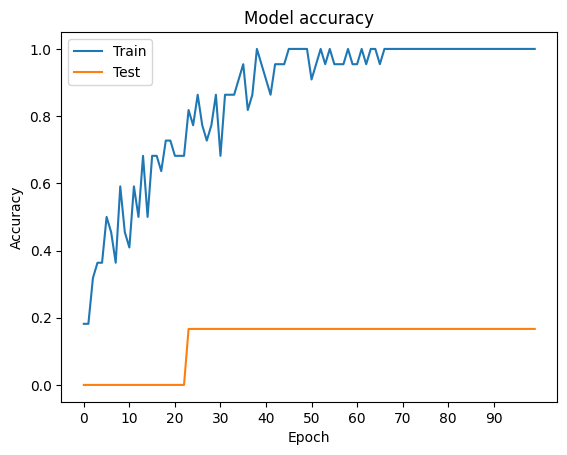

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(0, len(history.history['accuracy']), step=10))  # Set x-axis ticks
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Save the model
captioning_model.save('image_captioning_model.h5')

In [ ]:
# Load the model
from keras.models import load_model
captioning_model = load_model('image_captioning_model.h5')

In [ ]:
# Choose an image from the dataset
image = dataset['image'][3]  # Choose the first image

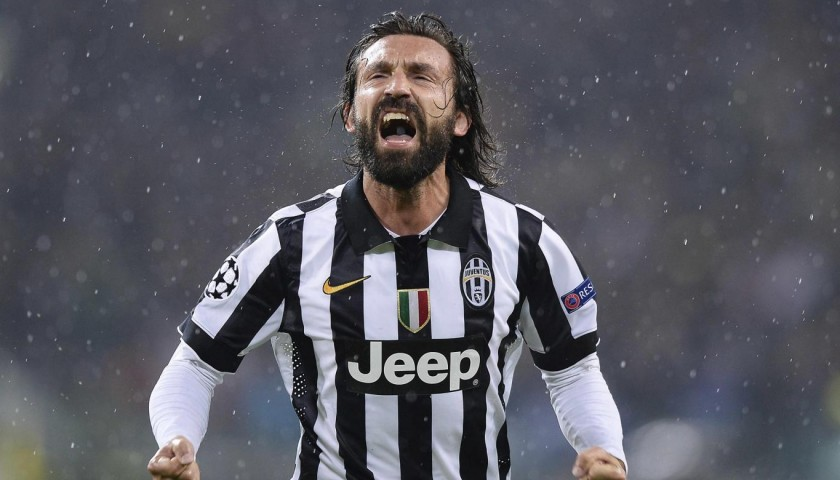

In [ ]:
image

In [ ]:
# Preprocess the image
image = preprocess_image(image)
image = np.expand_dims(image, axis=0)  # Adjust the image dimensions

# Predict the caption
def generate_caption(model, tokenizer, image, max_length):
    in_text = 'startseq'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

caption = generate_caption(captioning_model, tokenizer, image, max_length)
print('Caption:', caption)

1/1 [==============================] - 0s 48ms/step
Caption: startseq with with juventus in 2014 2014 2014 cup cup cup
